In [4]:
# Libraries, parameters

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import norm
from scipy.integrate import quad
from scipy.interpolate import interp1d
from scipy.signal import fftconvolve
from scipy.stats import poisson
from scipy.optimize import minimize
import math

# Norms for the PMNS matrix squared:
u_e = [0, 0.674743, 0.302844, 0.0224125]
u_m = [0, 0.0946105, 0.360415, 0.544974]
u_t = [0, 0.230646, 0.33674,  0.432613]


# Effective distance traveled in 1oeV:
l_eff = 4.4434e23 * 5.06773093741 * 1e6

# Importing hypotheses and bin edges
hypotheses = pd.read_csv('hypotheses.csv')
bin_edges = pd.read_csv('bin_edges.csv')

# concatenating
frames = [bin_edges, hypotheses]
ngc_chart = pd.concat(frames, axis=1)

# Importing effective area data:
eff_a = np.loadtxt('effA_-5to30.dat')

# Limits of energy bins in the effective area data:
e_min = 1e-1
e_max = 7.94328e5

# More parameters:
phi0 = 5e-11 * 275270400 # TeV^-1 cm^-2 over 3168 days
e0 = 1 # TeV
index = 3.2 # Taken from NGC paper
width = 0.3 # In log10 scale, for track-like events

# del_m2
del_m2 = 10**(-17.8)

base = 10

In [48]:
print(phi0)

0.013763520000000001


In [59]:
# Big Boy Integral Function: outputs entire event distribution for some PD hypothesis

def BigIntegral(del_m2):

    # Define the integrand functions
    def F(log_e_reco, del_m2):

        exp_e_reco = 10**(log_e_reco)

        flux = 3*phi0*(exp_e_reco/e0)**(-index)

        x = eff_a[:,0]
        y = eff_a[:,4]
        f = interp1d(x, y)
        effa = 10000*f(exp_e_reco)

        osc = (np.cos((del_m2 * l_eff)/(4*exp_e_reco*1e12)))**2
        prob_surv = osc * ((u_m[1]*u_m[1]) + (u_m[2]*u_m[2]) + (u_m[3]*u_m[3]))
        prob_emu = osc * ((u_e[1]*u_m[1]) + (u_e[2]*u_m[2]) + (u_e[3]*u_m[3]))
        prob_mu = 0.666666*prob_surv + 0.333333*prob_emu 

        fx = flux*effa*prob_mu

        return fx

    def G(log_e_reco):
        return (1/(width*np.sqrt(2*np.pi)))*np.exp(-0.5*((log_e_reco)/width)**2)

    # Define the bins
    num_bins = 10000
    a = np.linspace(-1, 3, num_bins)

    # Discretize F and G
    F_sample = []
    G_sample = []
    for i in range(num_bins):
        F_sample.append(F(a[i], del_m2))
        G_sample.append(G(a[i]))
  
    # Translation factor to make this fit with the expected results
    H = []
    for i in range(int(num_bins/2)):
        H.append(0)
    G_sample = H+G_sample

    # Convolve
    convolution = fftconvolve(F_sample, G_sample, mode='same')*(a[1]-a[0])
    b = np.linspace(-1, 3, len(convolution))
    FG = interp1d(b, convolution)

    # Take outside integral, first changing to log energy scale
    def NewIntegrand(log_e_reco):
        return np.log(10)*np.power(10, log_e_reco)*FG(log_e_reco)

    def FFTIntegral(log_e_start, log_e_end):
        return quad(NewIntegrand, log_e_start, log_e_end, limit=50, epsabs=0.5)[0]

    # record data
    int_FFT = []
    for i in range(len(ngc_chart['energy'])-1):
        e_t = np.log10(ngc_chart['energy'][i])
        e_t_next = np.log10(ngc_chart['energy'][i+1])
        int_FFT.append(FFTIntegral(e_t, e_t_next))
    int_FFT.append(0)

    return int_FFT

In [60]:
# Big Boy Integral Function with parameters allowed to vary

def BigIntegral1(del_m2, phi0, index):

    # Define the integrand functions
    def F(log_e_reco, del_m2):

        exp_e_reco = 10**(log_e_reco)

        flux = 3*phi0*(exp_e_reco/e0)**(-index)

        x = eff_a[:,0]
        y = eff_a[:,4]
        f = interp1d(x, y)
        effa = 10000*f(exp_e_reco)

        osc = (np.cos((del_m2 * l_eff)/(4*exp_e_reco*1e12)))**2
        prob_surv = osc * ((u_m[1]*u_m[1]) + (u_m[2]*u_m[2]) + (u_m[3]*u_m[3]))
        prob_emu = osc * ((u_e[1]*u_m[1]) + (u_e[2]*u_m[2]) + (u_e[3]*u_m[3]))
        prob_mu = 0.666666*prob_surv + 0.333333*prob_emu 

        fx = flux*effa*prob_mu

        return fx

    def G(log_e_reco):
        return (1/(width*np.sqrt(2*np.pi)))*np.exp(-0.5*((log_e_reco)/width)**2)

    # Define the bins
    num_bins = 10000
    a = np.linspace(-1, 3, num_bins)

    # Discretize F and G
    F_sample = []
    G_sample = []
    for i in range(num_bins):
        F_sample.append(F(a[i], del_m2))
        G_sample.append(G(a[i]))
  
    # Translation factor to make this fit with the expected results
    H = []
    for i in range(int(num_bins/2)):
        H.append(0)
    G_sample = H+G_sample

    # Convolve
    convolution = fftconvolve(F_sample, G_sample, mode='same')*(a[1]-a[0])
    b = np.linspace(-1, 3, len(convolution))
    FG = interp1d(b, convolution)

    # Take outside integral, first changing to log energy scale
    def NewIntegrand(log_e_reco):
        return np.log(10)*np.power(10, log_e_reco)*FG(log_e_reco)

    def FFTIntegral(log_e_start, log_e_end):
        return quad(NewIntegrand, log_e_start, log_e_end, limit=50, epsabs=0.5)[0]

    # record data
    int_FFT = []
    for i in range(len(ngc_chart['energy'])-1):
        e_t = np.log10(ngc_chart['energy'][i])
        e_t_next = np.log10(ngc_chart['energy'][i+1])
        int_FFT.append(FFTIntegral(e_t, e_t_next))
    int_FFT.append(0)

    return int_FFT

In [114]:
# LRT Functions

def Poissonlog(data, hyp):
    return np.log((hyp**data)*np.exp(-hyp)/math.gamma(data + 1))

def Poisson(data, hyp):
    return (hyp**data)*np.exp(-hyp)/math.gamma(data + 1)

def LRT(test, del_m2):
    # test is a tuple: (phi_0_test, index_test)
    hyp_null = BigIntegral1(0, phi0, index)
    hyp_alt = BigIntegral1(del_m2, test[0], test[1])

    summand_alt = np.zeros(len(hyp_null))

    for i in range(len(hyp_null)):
        summand_alt[i] = Poissonlog(hyp_null[i], hyp_alt[i]) - Poissonlog(hyp_null[i], hyp_null[i])

    ts_alt = -2*sum(summand_alt)

    return ts_alt

In [47]:
# Goal: to minimize the LRT function
bnds = ((0, None), (0, 8))
def MinLRT(del_m2):
    x0 = (phi0, index)
    min_lrt = minimize(LRT, x0, args=(del_m2, ), method="SLSQP", bounds=bnds, tol=0.5)
    return min_lrt

In [111]:
# Goal: to maximize the Poissonlog function for the alternative hypotheses
def MaxLH(del_m2):

    def NegLH(test, del_m2):
        hyp_null = BigIntegral1(0, phi0, index)
        hyp_alt = BigIntegral1(del_m2, test[0], test[1])

        summand_alt = np.zeros(len(hyp_null))
        for i in range(len(hyp_null)):
            summand_alt[i] = Poissonlog(hyp_null[i], hyp_alt[i])
        
        poisson_lh = np.sum(summand_alt)

        return -poisson_lh

    bnds = ((phi0/2, 0.04128), (1, 5))
    x0 = (phi0, index)
    min_neglh = minimize(NegLH, x0, args = (del_m2, ), method="SLSQP", bounds=bnds, tol=0.01)

    return min_neglh.x # first element in the array is max_lh phi0, second element is max_lh index


In [132]:
# Test out a delm2 PD hypothesis and maximize Poisson likelihood

test_del_m2 = 10**(-17.9)
test = MaxLH(test_del_m2)
print(f"max LH params: {test}")
test_maxlh = (test[0], test[1])
test_LRT = LRT(test_maxlh, test_del_m2)
print(f"max LH LRT: {test_LRT}")

max LH params: [0.02459377 3.45189896]
max LH LRT: 5.485387996506199


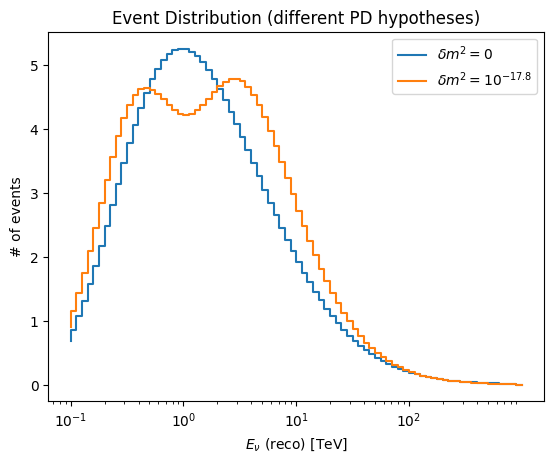

In [131]:
# Plot Event Distributions of Max LH alt hyps:

fig, ax = plt.subplots()
intFFT_null, = ax.step(ngc_chart['energy'], BigIntegral(0))
intFFT_178, = ax.step(ngc_chart['energy'], BigIntegral1(test_del_m2, test[0], test[1]))
# intFFT_20, = ax.step(ngc_chart['energy'], BigIntegral(10**(-20)))
ax.set_xscale('log')
ax.set_xticks([10**-1, 10**0, 10**1, 10**2])
ax.set_xlabel(r"$E_{\nu}$ (reco) [TeV]")
ax.set_ylabel(r"# of events")
# ax.set_title(r"$\delta m^2 = 0$ eV$^2$", loc="left")
ax.set_title(r"Event Distribution (different PD hypotheses)", loc="center")
ax.legend([intFFT_null, intFFT_178], [r"$\delta m^2 = 0$", r"$\delta m^2 = 10^{-17.8}$"])

In [124]:
# Apply the MaxLH alt hypothesis to the LRT function

min_del = -19
max_del = -14
num_bins = 30

dm2s = np.linspace(min_del, max_del, num_bins)

test_stats = []

for i in range(len(dm2s)):
    max_lh = MaxLH(10**(dm2s[i]))
    test_maxlh = (max_lh[0], max_lh[1])
    test_stats.append(LRT(test_maxlh, 10**(dm2s[i])))

/var/folders/f1/m1ggk_2j6sg3vl8gbd6xc_080000gn/T/ipykernel_16175/3164174864.py:4: RuntimeWarning: divide by zero encountered in log
  return np.log((hyp**data)*np.exp(-hyp)/math.gamma(data + 1))


In [127]:
np.savetxt("LRT_first_stats.dat", test_stats)

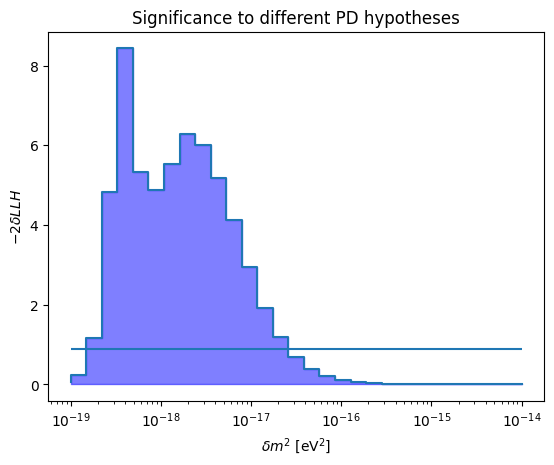

In [137]:
bins = np.logspace(min_del, max_del, num_bins)

fig, ax = plt.subplots()
intFFT_null, = ax.step(bins, test_stats)
ax.set_xscale('log')
ax.set_xticks([10**(-19), 10**(-18), 10**(-17), 10**(-16), 10**(-15), 10**(-14)])
ax.set_xlabel(r"$\delta m^2$ [eV$^2$]")
ax.set_ylabel(r"$-2\delta LLH$")
# ax.set_title(r"$\Delta m^2 = 0$ eV$^2$", loc="left")
ax.set_title(r"Significance to different PD hypotheses", loc="center")
ax.fill_between(bins, test_stats, 0, color='blue', alpha=.5, step='pre')
ax.hlines(y=0.89, xmin=bins[0], xmax = bins[num_bins-1])